In [1]:
from nrc import *
import pandas as pd
import os.path
from os import path
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('seaborn-whitegrid')

# constants and setup
FILENAME = 'data/swedish_news.txt'
FILTERS = set(stopwords.words('swedish')) | set(string.punctuation) | {'--', '“', '”', '’'}

sentiments = ['negative', 'positive']
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

lexicon = load_translated_lexicon('data/NRC-lexicon-sv.txt')

...Loading translated NRC lexicon.


In [2]:
# get token vectors
token_vectors = get_token_vectors_from_text(FILENAME, lexicon, FILTERS)

# filter out token_vectors with less than sum of 50
token_vectors = {
    t: v for (t, v) in token_vectors.items() if v.sum() > 50
}

# create emotion vectors
emotion_vectors = {
    t: np.concatenate([v[:5], v[7:]]) for (t, v) in token_vectors.items()
}

# create sentiment vectors
sentiment_vectors = {
    t: v[5:7] for (t, v) in token_vectors.items()
}

normalize_token_vectors(emotion_vectors)
normalize_token_vectors(sentiment_vectors)

emotion_df = pd.DataFrame(data=emotion_vectors.values(), index=emotion_vectors.keys(), columns=emotions)
sentiment_df = pd.DataFrame(data=sentiment_vectors.values(), index=sentiment_vectors.keys(), columns=sentiments)

# convert index into column with name "word"
sentiment_df.reset_index(inplace=True)
sentiment_df = sentiment_df.rename(columns = {'index':'word'})

emotion_df.reset_index(inplace=True)
emotion_df = emotion_df.rename(columns = {'index':'word'})

...Loading data from data/swedish_news.txt.
...Normalizing token vectors.
...Normalizing token vectors.


In [3]:
# view first columns
sentiment_df.head()

word  negative  positive
0      både  0.336000  0.664000
1  covid-19  0.402439  0.597561
2   problem  0.577778  0.422222
3   skriver  0.371069  0.628931
4    danska  0.404040  0.595960

In [4]:
# view first columns
emotion_df.head()

word     anger  anticipation   disgust      fear       joy   sadness  \
0      både  0.128866      0.159794  0.082474  0.154639  0.113402  0.139175   
1  covid-19  0.066667      0.192593  0.066667  0.200000  0.037037  0.214815   
2   problem  0.073620      0.098160  0.061350  0.257669  0.073620  0.245399   
3   skriver  0.125541      0.190476  0.086580  0.151515  0.082251  0.138528   
4    danska  0.128000      0.166667  0.085333  0.161333  0.077333  0.138667   

   surprise     trust  
0  0.041237  0.180412  
1  0.029630  0.192593  
2  0.049080  0.141104  
3  0.017316  0.207792  
4  0.042667  0.200000

In [7]:
queries = ['danmark', 'dansk', 'danskar', 'danska']

danish_sent = sentiment_df[sentiment_df['word'].isin(queries)]

danish_sent

word  negative  positive
4     danska  0.404040  0.595960
13   danmark  0.397456  0.602544
92   danskar  0.478261  0.521739
165    dansk  0.342105  0.657895

In [8]:
danish_em = emotion_df[emotion_df['word'].isin(queries)]

danish_em

word     anger  anticipation   disgust      fear       joy   sadness  \
4     danska  0.128000      0.166667  0.085333  0.161333  0.077333  0.138667   
13   danmark  0.108221      0.210198  0.059313  0.167534  0.073881  0.140479   
92   danskar  0.100000      0.169231  0.084615  0.192308  0.076923  0.146154   
165    dansk  0.118881      0.160839  0.111888  0.160839  0.083916  0.160839   

     surprise     trust  
4    0.042667  0.200000  
13   0.054110  0.186264  
92   0.069231  0.161538  
165  0.027972  0.174825

In [11]:
fig = px.bar(danish_sent.sort_values(by=['word'], ascending=False), y='positive', color='word', x='word', range_y=[0, 1] )

fig.add_hline(y=0.5)

fig.show()

In [12]:
fig = px.bar(danish_em, y='anger', color='word', x='word', range_y=[0, 1] )

fig.add_hline(y=0.5)

fig.show()

In [26]:
danish_words = ['danmark', 'dansk', 'danskar']
swedish_words = ['sverige', 'svensk', 'svenskar']

# add nordic column
sentiment_df['nordic'] = ['d' if x in danish_words else 's' if x in swedish_words else 'n' for x in sentiment_df['word']]
emotion_df['nordic'] = ['d' if x in danish_words else 's' if x in swedish_words else 'n' for x in emotion_df['word']]

nordic_sentiments = sentiment_df.loc[(sentiment_df['nordic'] == 'd') | (sentiment_df['nordic'] == 's')]
nordic_emotions = emotion_df.loc[(emotion_df['nordic'] == 'd') | (emotion_df['nordic'] == 's')]

#nordic_sentiments.to_csv('results/nordic/svt_sentiments.csv')
#nordic_emotions.to_csv('results/nordic/svt_emotions.csv')

In [27]:
fig = px.bar(nordic_sentiments, y='positive', color='nordic', x='word', range_y=[0, 1])
fig.add_hline(y=0.5)
fig.show()

In [28]:
# ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

In [35]:
emotion = 'sadness'

fig = px.bar(nordic_emotions.sort_values(by=[emotion], ascending=False), y=emotion, color='nordic', x='word', range_y=[0, 1])
fig.add_hline(y=0.125)
fig.show()

In [9]:
emotion = 'joy'

sortaro = emotion_df.sort_values(by=[emotion], ascending=False).head(5)

#sortaro['joy'].plot(kind='bar')
fig = px.bar(
        sortaro, y=emotion, color='word', x='word' 
      )
fig.show()

In [12]:
# 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'

emotion = 'fear'

gender_emotion = emotion_df.loc[(emotion_df['gender'] == 'm') | (emotion_df['gender'] == 'f')]

filters = ['ordinary', 'bag', 'cat', 'dog', 'stiff', 'wolf', 'tom', 'town']

for filt in filters:
    gender_emotion = gender_emotion[gender_emotion['word'] != filt]
    
sortaro = gender_emotion.sort_values(by=[emotion], ascending=False)

fig = px.bar(
        sortaro, y=emotion, color='gender', x='word' 
      )
fig.show()


In [7]:
get_similarity(emotion_vectors, 'woman', 'bloom')

woman not in token database,
bloom not in token database,


In [8]:
emotion_df.loc[['man', 'woman', 'boy', 'girl']]

/Users/fluffy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



anger  anticipation   disgust      fear       joy   sadness  \
man    0.109516      0.158958  0.056885  0.167464  0.129718  0.099947   
woman       NaN           NaN       NaN       NaN       NaN       NaN   
boy    0.075893      0.120536  0.191964  0.133929  0.111607  0.116071   
girl        NaN           NaN       NaN       NaN       NaN       NaN   

       surprise     trust  
man    0.076555  0.200957  
woman       NaN       NaN  
boy    0.071429  0.178571  
girl        NaN       NaN

In [9]:
sentiment_df.loc[['man', 'woman', 'boy', 'girl']]

/Users/fluffy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



negative  positive
man    0.414013  0.585987
woman       NaN       NaN
boy    0.519737  0.480263
girl        NaN       NaN

In [1]:
get_most_similar(emotion_vectors, 'girl', 10)

NameError: name 'get_most_similar' is not defined

In [9]:
sentiment_df.sort_values(by=['positive'], ascending=False)

negative  positive
romantic   0.052632  0.947368
prince     0.055556  0.944444
birth      0.058824  0.941176
service    0.066667  0.933333
pray       0.100000  0.900000
...             ...       ...
omen       0.888889  0.111111
dens       0.916667  0.083333
destroyed  0.928571  0.071429
agony      0.933333  0.066667
shot       0.961538  0.038462

[1051 rows x 2 columns]

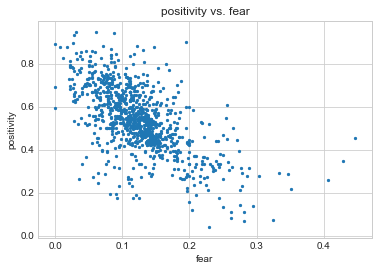

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

emotion = 'fear'

e_index = {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}
e = e_index[emotion]

# trust versus positivity
x_values = [v[e] for v in emotion_vectors.values()]
y_values = [v[1] for v in sentiment_vectors.values()]

plt.title(f'positivity vs. {emotion}')
plt.xlabel(emotion)
plt.ylabel('positivity')

plt.scatter(x_values, y_values, s=5)

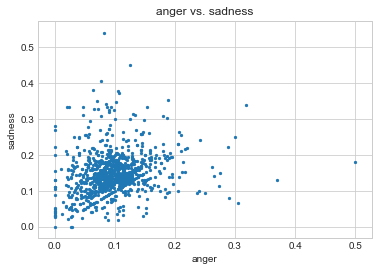

In [57]:
emotion1 = 'anger'
emotion2 = 'sadness'

e_index = {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}

e1 = e_index[emotion1]
e2 = e_index[emotion2]

# trust versus positivity
x_values = [v[e1] for v in emotion_vectors.values()]
y_values = [v[e2] for v in emotion_vectors.values()]

plt.title(f'{emotion1} vs. {emotion2}')
plt.xlabel(emotion1)
plt.ylabel(emotion2)

plt.scatter(x_values, y_values, s=5)

In [24]:
from collections import Counter

# get most common words in book
# open and read the contents of a file
with open(FILENAME) as f:
    data = f.read()

# clean the data
data = data.replace('_', '') # note to self: italics words
data = data.replace('\n', ' ')
data = data.replace('"', '')
data = data.lower()

words = word_tokenize(data)
words = [w for w in words if w not in FILTERS]

word_collection = Counter(words)



In [25]:
word_collection.most_common(10)

[('one', 433),
 ("n't", 418),
 ('dorian', 414),
 ('would', 312),
 ('said', 262),
 ("'s", 259),
 ('lord', 248),
 ('henry', 236),
 ('life', 229),
 ('like', 210)]

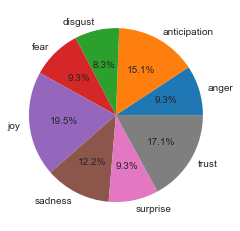

In [47]:
labels = e_index.keys()
plt.pie(emotion_vectors['girl'], labels=labels, autopct='%1.1f%%')
plt.show()

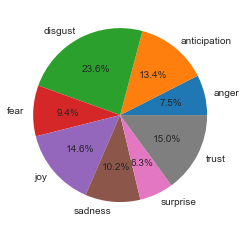

In [48]:
plt.pie(emotion_vectors['boy'], labels=labels, autopct='%1.1f%%')
plt.show()